In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import json
import pandas as pd
import time

In [2]:
def get_vortices_coordinates(mask, frame):
    _, contours, hierarchy= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    vortices_list = []
    for (i,c) in enumerate(contours):
        ''' FIRST VERSION '''
#         cx= int(c[0][0][0] * frame.shape[0] / mask.shape[0])
#         cy= int(c[0][0][1] * frame.shape[0] / mask.shape[0])
        
        ''' SECOND VERSION - BETTER '''
        middle_pixel = int(len(c) / 2)
        cx= int(c[middle_pixel][0][0] * frame.shape[0] / mask.shape[0])
        cy= int(c[middle_pixel][0][1] * frame.shape[0] / mask.shape[0])
        vortices_list.append((cx, cy))
    return vortices_list

# EXTRACTION MOMENTS OF TIME FOR WHICH THE DATA IS LABELED

In [3]:
''' EXTRACT TIME RANGE '''
mypath = 'CalculateDetectionMetrics/cropped_data_labeled/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
time_range = np.array(sorted([float(x[19:-5]) for x in list(filter(lambda s: 'json' in s, onlyfiles))]))
time_range = time_range[time_range >= 30]
time_range = np.round(time_range, 1)
time_range

array([ 30. ,  33. ,  36. ,  39. ,  42.1,  45. ,  48. ,  51. ,  54. ,
        57. ,  60. ,  63. ,  66. ,  69. ,  72. ,  75. ,  78. ,  81. ,
        84. ,  87. ,  90. ,  93. ,  96. ,  99. , 102. , 105. , 108. ,
       111. , 114. , 117. , 120. , 123. , 126. , 129. , 132. , 135. ,
       138. , 141. , 144. , 147. , 150. , 153. , 156. , 159. , 162. ,
       165. , 168. , 171. , 174. , 177. , 180. , 183. , 186. , 189. ,
       192. , 195. , 198. , 201. , 204. , 207. , 210.1, 214. , 217. ,
       220. , 223. , 226. , 229. , 232. , 235. , 238. , 241. , 244. ,
       247. , 250. , 253. , 256. , 259. , 262. , 265. , 268. , 271. ,
       274. , 277. , 280. , 283. , 286. , 289. , 292. , 295. , 298. ,
       301. , 304. , 307. , 310. , 313. , 316. , 319. , 322. , 325. ,
       328. ])

# METHOD 2 ALGORITHM

In [4]:
program_starts = time.time()

detected_vortices = {}

for t in time_range:
    frame = cv2.imread(f'CalculateDetectionMetrics/cropped_data_labeled/x_vel_cropped_time={np.round(t, 1)}0.png')
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = img[20:1230, 20:1230]
    gradx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    grady = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    gradmag = cv2.magnitude(gradx,grady)
    ret,mask = cv2.threshold(gradmag,240,255,cv2.THRESH_BINARY)
    # kernel = np.ones((2,2), dtype='uint8')
    # mask = cv2.dilate(mask, kernel)
    # mask = 255 - mask
    mask = mask.astype('uint8')
    
    '''GET DETECTED VORTICES COORDINATES'''
    detected_vortices[np.round(t,1)] = get_vortices_coordinates(mask, frame)

now = time.time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

It has been 6.559266805648804 seconds since the loop started


Text(0.5, 1.0, 'MASK FOR T=328.0')

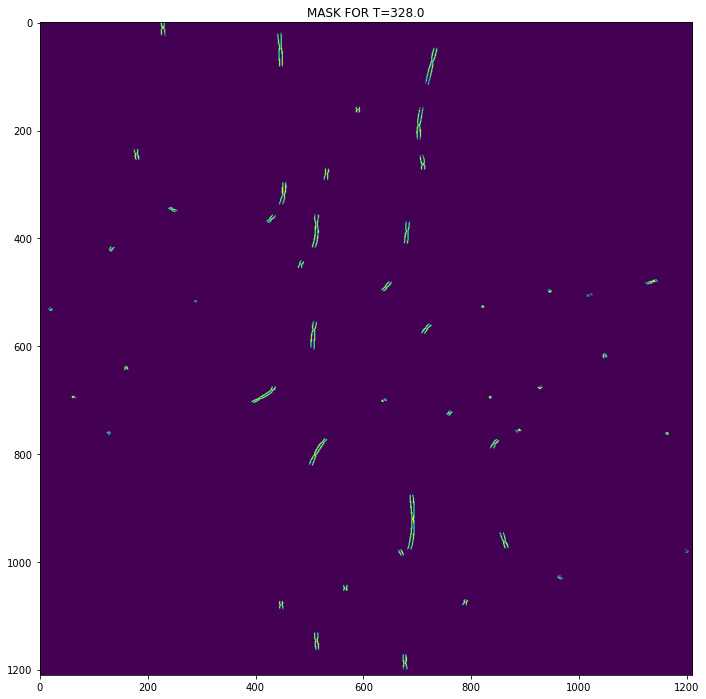

In [52]:
# _, contours, hierarchy= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# vortices_list = []
# for (i,c) in enumerate(contours):
#     middle_pixel = int(len(c) / 2)
#     cx= int(c[middle_pixel][0][0])# * frame.shape[0] / mask.shape[0])
#     cy= int(c[middle_pixel][0][1])# * frame.shape[0] / mask.shape[0])
#     vortices_list.append((cx, cy))

# for (x,y) in vortices_list:
#     color = (255,255,255)
#     cv2.rectangle(mask, (x-12,y-12), (x+12,y+12), color, 1)

plt.figure(figsize=(12,12))
plt.imshow(mask)
plt.title(f'MASK FOR T={t}')

# TP, FP, FN METRICS CALCULATIONS

In [49]:
''' READ JSON FILES WITH LABELED BOUNDING BOXES '''
bbox_size = 3
for index, t in enumerate(time_range):
    with open(f'CalculateDetectionMetrics/cropped_data_labeled/x_vel_cropped_time={np.round(t,1)}0.json', 'r') as f:
        dictData = json.load(f)
    frame = cv2.imread(f'CalculateDetectionMetrics/cropped_data_labeled/x_vel_cropped_time={np.round(t,1)}0.png')
    TP = []
    for i, vortex in enumerate(dictData['shapes']):
        labeled_mask = np.zeros((frame.shape[:2]), dtype='uint8')
        a = int(vortex['points'][0][0])
        b = int(vortex['points'][0][1])
        c = int(vortex['points'][1][0])
        d = int(vortex['points'][1][1])
    #         print(f'vortex {i+1}', a, b, c, d)
        cv2.rectangle(labeled_mask, (a,b), (c,d), 255, cv2.FILLED)
        for x,y in detected_vortices[np.round(t,1)]:
            if (x,y) not in TP:
                detected_vortex = np.zeros((frame.shape[:2]), dtype='uint8')
                cv2.rectangle(detected_vortex, (x-bbox_size,y-bbox_size), (x+bbox_size,y+bbox_size), 255, cv2.FILLED)
                result = np.all(cv2.bitwise_and(detected_vortex, labeled_mask) == 0)
                if not result:
                    TP.append((x,y))
                    break
    tp_count = len(TP) #CORRECT
    fp_count = len(detected_vortices[np.round(t,1)]) - len(TP) #INCORRECT
    fn_count = len(dictData['shapes']) - len(TP) #UNDETECTED
    
    ''' INSPECTION IF CALCULATION WORK PROPERLY '''
    if index % 10 == 0:
        for (x,y) in detected_vortices[np.round(t,1)]:
            if (x,y) in TP:
                color = (0,255,0)
            else:
                color = (0,0,255)
            cv2.rectangle(frame, (x-12,y-12), (x+12,y+12), color, 2)
        for parameter, value, shift in zip(['T=', 'TP=', 'FP=', 'FN='], [t, tp_count, fp_count, fn_count], [30, 60, 90, 120]):
            cv2.putText(frame, text=parameter+str(value), org=(10, shift),
                    fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=(0,0,0),
                    thickness=1, lineType=cv2.LINE_AA)
        cv2.imwrite(f'Method2-GradientofRGBpicture_RESULTS/TP_FP_{np.round(t,1)}.png', frame)
        print(t)
    ''' SAVE RESULTS TO FILE '''
#     print(t, tp_count, fp_count, fn_count)
    with open('Method2-GradientofRGBpicture_RESULTS/Method2-Detection-Metrics-Results.csv', 'a') as fr:
        fr.write(f'{t}\t{tp_count}\t{fp_count}\t{fn_count}\n')

30.0
60.0
90.0
120.0
150.0
180.0
210.1
241.0
271.0
301.0


# FINAL METRICS SUMMATION

In [45]:
df_metrics = pd.read_csv('Method2-GradientofRGBpicture_RESULTS/Method2-Detection-Metrics-Results.csv', header=None, delimiter='\t')
df_metrics.columns = ['TIME', 'TP', 'FP', 'FN']
df_metrics.set_index('TIME', inplace=True)
df_metrics

,TP,FP,FN
TIME,,,
30.0,4,3,1
33.0,1,10,5
36.0,2,4,4
39.0,2,7,3
42.1,0,1,2
...,...,...,...
316.0,24,43,20
319.0,20,39,22
322.0,27,34,21


In [46]:
df_metrics.sum()

TP     936
FP    2708
FN    1417
dtype: int64

In [51]:
df_metrics = pd.read_csv('Method2-GradientofRGBpicture_RESULTS/Method2-Detection-Metrics-Results____VERSION_2.csv', header=None, delimiter='\t')
df_metrics.columns = ['TIME', 'TP', 'FP', 'FN']
df_metrics.set_index('TIME', inplace=True)
df_metrics.sum()

TP    1121
FP    2523
FN    1232
dtype: int64

# SAVE TO FILE DETECTED COORDINATES

In [5]:
with open('Method2-GradientofRGBpicture_RESULTS/detected_vortices.txt','w') as data: 
      data.write(str(detected_vortices))